In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ParameterGrid

In [3]:
plt.style.use('dark_background')

### Read in all files

In [4]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
cosmx_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Cosmx_mouse_filtered.h5ad")
cosmx_scdata

AnnData object with n_obs × n_vars = 132721 × 950
    obs: 'total_counts', 'leiden', 'celltype'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
cbm2_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Gellyfish Analysis\CBM2_new_immmature_dg.h5ad")
cbm2_scdata

AnnData object with n_obs × n_vars = 57489 × 223
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'Experiment', 'Age', 'Mouse', 'Section', 'Treatment', 'celltype', 'MERFISH celltype', 'general_celltype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

### Subset by sample

In [7]:
xenium_scdata.X = xenium_scdata.X.toarray()
xenium_scdata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.35279253,
        0.        ],
       ...,
       [0.44123012, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [8]:
xenium_c24m2 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C24m2']
xenium_c24m2

View of AnnData object with n_obs × n_vars = 54061 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
right_side_scdata = cosmx_scdata[cosmx_scdata.obsm['X_spatial'][:, 0] >= -445000]
hd_175_2_scdata = right_side_scdata[right_side_scdata.obsm['X_spatial'][:, 1] > 15000]
hd_175_2_scdata

View of AnnData object with n_obs × n_vars = 31027 × 950
    obs: 'total_counts', 'leiden', 'celltype'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Subset by intersection

In [10]:
adata_ref = cbm2_scdata
adata_xenium = xenium_c24m2
adata_cosmx = hd_175_2_scdata

In [11]:
shared = adata_ref.var_names.intersection(adata_xenium.var_names).intersection(adata_cosmx.var_names)
shared

Index(['Acta2', 'Aqp4', 'Bdnf', 'Calb1', 'Cldn5', 'Fos', 'Gad1', 'Gfap',
       'Gpr17', 'Npy2r', 'Pdgfra', 'Slit2', 'Vip'],
      dtype='object')

In [12]:
adata_xenium = adata_xenium[:, shared]
adata_cosmx = adata_cosmx[:, shared]
adata_ref = adata_ref[:, shared]

### Preprocess adata_ref

In [13]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Ingestion of Xenium (C24m2) into Cbm2

In [14]:
sc.tl.ingest(adata_xenium, adata_ref, obs= "general_celltype")

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


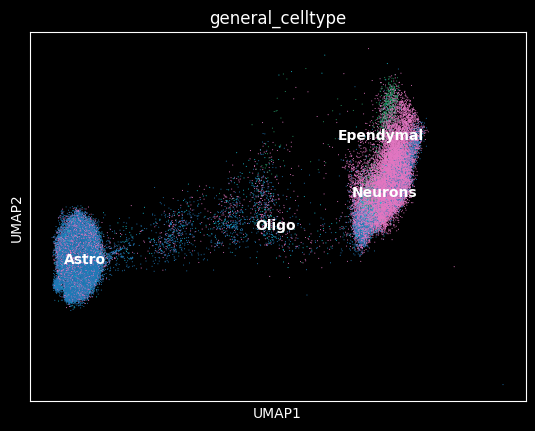

In [15]:
sc.pl.umap(adata_xenium, color = 'general_celltype', legend_loc = 'on data')

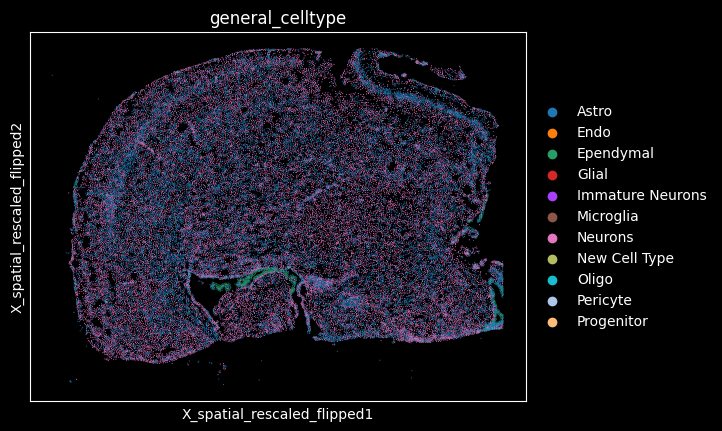

In [16]:
sc.pl.embedding(adata_xenium, basis = 'X_spatial_rescaled_flipped', color = 'general_celltype')

In [17]:
adata_xenium.obs['general_celltype'].value_counts()

Neurons             28044
Astro               23022
Oligo                2043
Ependymal             952
Endo                    0
Glial                   0
Immature Neurons        0
Microglia               0
New Cell Type           0
Pericyte                0
Progenitor              0
Name: general_celltype, dtype: int64

### Ingestion of Cosmx (Hd_175_2) into Cbm2

In [18]:
sc.tl.ingest(adata_cosmx, adata_ref, obs="general_celltype")

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


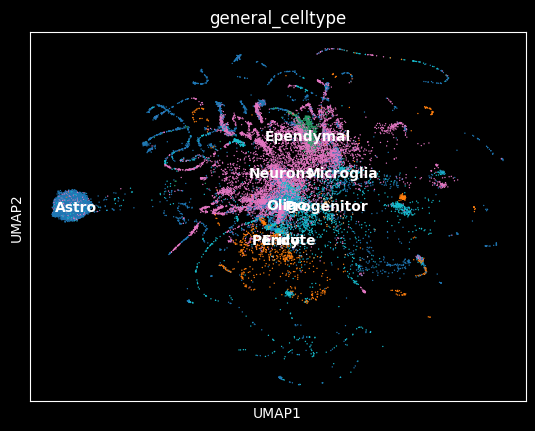

In [19]:
sc.pl.umap(adata_cosmx, color = 'general_celltype', legend_loc = 'on data')

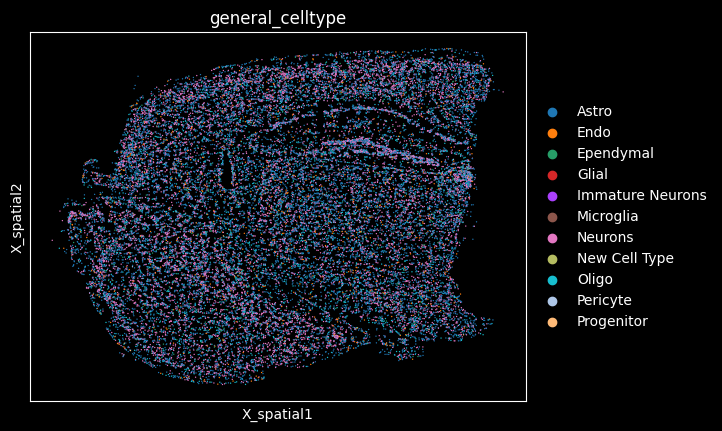

In [20]:
sc.pl.embedding(adata_cosmx, basis = 'X_spatial', color = 'general_celltype')

In [21]:
adata_cosmx.obs['general_celltype'].value_counts()

Astro               14386
Neurons             10941
Oligo                3710
Endo                 1014
Ependymal             856
Progenitor             54
Pericyte               35
Microglia              31
Glial                   0
Immature Neurons        0
New Cell Type           0
Name: general_celltype, dtype: int64

### Cbm2

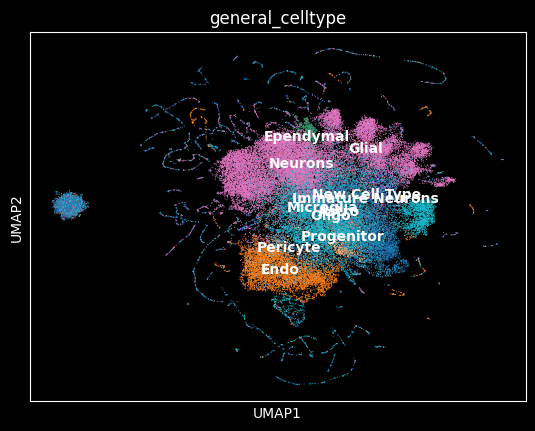

In [22]:
sc.pl.umap(adata_ref, color = 'general_celltype', legend_loc = 'on data')

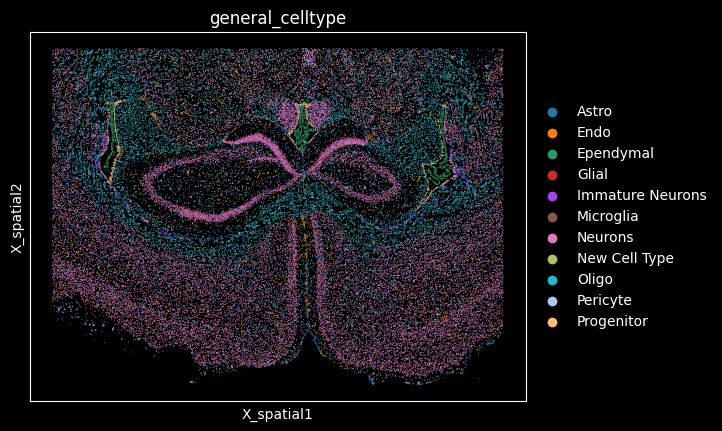

In [23]:
sc.pl.embedding(adata_ref, basis = 'X_spatial', color = 'general_celltype')